#Hurricane Forecast - Hugo

Welcome to the Hurricane Forecast-Hugo tool. This solution allows the user to predict the progression of hurricane given a series of satelite images using a Machine Learning based model.

The model design is based on recent research carried out in image forecasting. We have reviewed a series of papers and latest research to design and build  the most optimal model for hurricane forecast. The underlying data used for model training is from Radiant Earth Foundation that contains images of hurricanes as well as the corresponding wind speeds.

This solution is a step-by-step guide that allows the user to process the data and understand key qualities of hurricane and then re-train the model on their own hurricane images in order to predict the next few images.

### Table of Contents

* [Set Up](#setup)
* [Data Load](#Data)
    * [Data Upload](#data_load)
    * [Data Checks](#data_checks)
* [Data Description](#data_processing)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)
* [Machine Learning Model Set Up](#MLmodel)
    * [Data Preparation](#data_prep)
    * [Section 2.2](#section_2_2)
* [Results](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)


## Set Up <a class="anchor" id="first-bullet"></a>

Run the following cells to import the required packages. Please ensure the HurricaseForecast folder is saved in the same folder as this notebook.

In [1]:
# Import the required modules
import json
import re
from glob import glob
import tarfile

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import torchvision
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader

!pip install livelossplot
!pip install radiant_mlhub #install module to connet to Radiant Ml Hub
from livelossplot import PlotLosses
# get the mlhub api key into the enviromental varible
import os
os.environ['MLHUB_API_KEY'] = 'a8dd9b80c37367283a6cc14ab36c968617619350dd230264d7cb32cbb9e90f1d'
# Hurricane Forecast module with the data processing and Machine Learning model

import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

# if running on google colab make use of the GPU
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cuda installed! Running on GPU!


In [2]:
import HurricaneForecast

The following cells are required for setting up connection to Radiant ML Hub for loading available data on hurricanes. If data is available else where, then running following cells is not required.

In [ ]:

!mlhub configure # Set up the API Key from the website. This is unique to each user, past API key below upon request



API Key: ac130b7f9dc6073241b128910f6fe507b4c6db4184a3d50e503ab4b679889a0f
Wrote profile to /root/.mlhub/profiles


## Data Upload<a class="anchor" id="first-bullet"></a>


#### Data Upload <a class="anchor" id="data_load"></a>

The data should be saved in the following format, where there is a folder for each image with the image_id in the directory name. This will allow the Data class to process the data and convert the features to pandas DataFrame and for the images to be aggregated to a Tensor.




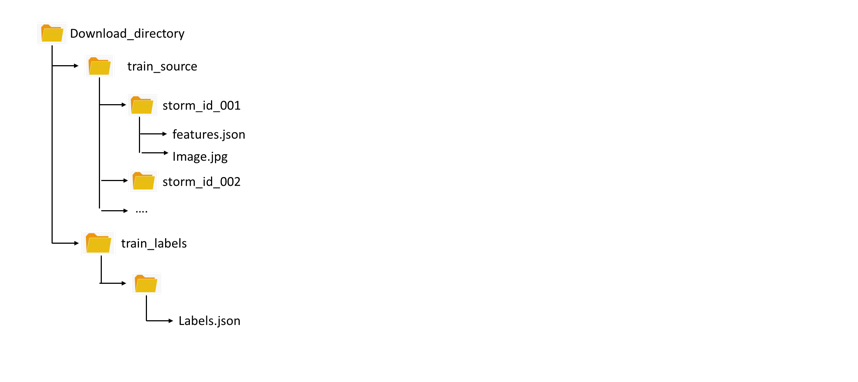

Run the following cells to process the data.

In [3]:
## Use this cell to connect to Google Drive if running on Google Colab
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
#******************User Input Required *************************

download_directory = Path('/content/gdrive/MyDrive/test').expanduser().resolve()#Specify the directory with data, use '.' for current directory
train_source = 'nasa_tropical_storm_competition_surprise_storm_source' # directory name with image.jpeg file and features.json and stac.json
train_labels = 'nasa_tropical_storm_competition_surprise_storm_labels' #  directory name with wind speed and stac.json


In [5]:
# Load the data from directories and create a pandas DataFrame to be  parsed into the class

train_data = []
jpg_names = glob(str(download_directory / train_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)
    
    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]
    labels_path = str(jpg_path.parent / 'labels.json').replace(train_source, train_labels)

    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)
        
    # Load the labels data
    with open(labels_path) as src:
        labels_data = json.load(src)

    train_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
        int(labels_data['wind_speed'])
    ])

train_df = pd.DataFrame(
    np.array(train_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean', 'Wind Speed'] # contain space may be no convinent for indexing
).sort_values(by=['Storm ID']).reset_index(drop=True)

train_df['Wind Speed'] = train_df['Wind Speed'].apply(int)
train_df['Relative Time'] = train_df['Relative Time'].apply(int)

train_df = train_df.sort_values(by=['Storm ID','Image ID']).reset_index(drop=True)
train_df.head()

,Image ID,Storm ID,Relative Time,Ocean,Wind Speed
0,sss_001,sss,437401,1,120
1,sss_002,sss,439200,1,121
2,sss_003,sss,442800,1,124
3,sss_004,sss,448200,1,128
4,sss_005,sss,453600,1,130


In [6]:
# Parse the DataFrame into HurricaneForecast data
data = HurricaneForecast.DataChecks(download_directory, train_source, train_labels, provide_df = True, df=train_df)
data.df.head()

,Image ID,Storm ID,Relative Time,Ocean,Wind Speed
0,sss_001,sss,437401,1,120
1,sss_002,sss,439200,1,121
2,sss_003,sss,442800,1,124
3,sss_004,sss,448200,1,128
4,sss_005,sss,453600,1,130



#### Data Checks <a class="anchor" id="data_checks"></a>

Real data often has inconsistencies and imperfections. The following cells will perform a series of checks to ensure the format and quality of data is sufficient to produce reliable results.  In case of any inconsistencies or if data fails to meet the quality checks, a warning will be issued.

The data is expected in the following format:

* 366x366 pixels
* the images are in grayscale, i.e. there is 1 channel input
* the images should be spaced every 30 minutes


In [7]:
#### Perform a series of data checks
data.check_shapes() # check thet image shape, including the number of channels
data.check_time_gaps() # check the largest gap in size

All images are of size 366x366 with 1 channel
Largest time gap 9001 at index 54


In [ ]:
## There is a unexpected gap in the data. Check the gap difference in hours
gap_in_hours = 9001/3600
print("The gap in hours is",round(gap_in_hours,2))

# Check the number of available images and what time period the images are over
print("There are ", data.count_images(), " images available for the storm, over", round((data.df.loc[data.df.index[-1], 'Relative Time'] - data.df['Relative Time'][0] )/3600,2), " hours of images")

The gap in hours is 2.5
There are  100  images available for the storm, over 78.5  hours of images


### Data Description

Let us print the wind speed over time and understand how the data is spaced.
The function below will calculate the average speed and plot it.

The average wind speed of the storm is 111.5


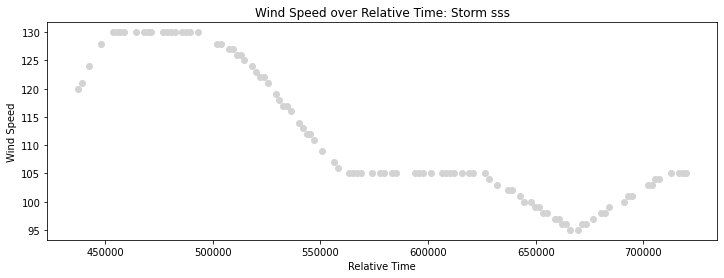

In [ ]:
print("The average wind speed of the storm is", data.average_wind_speeds())
data.plot_wind_speeds()

Show the hurricane image at the different wind speeds, so we can understand how it looks like if at the fastest and slowest speeds. This can also help us understand if there might be any percularities in the data that may need to be accounted for.

The image at fastest speed at Image ID=sss_005  at time 


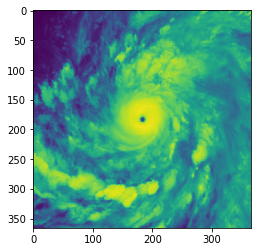

The image at slowest speed at Image ID= sss_082  at time 665999


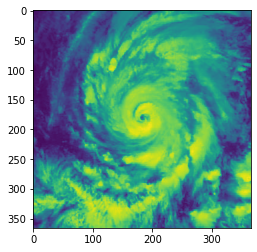

The random image at at time 716401


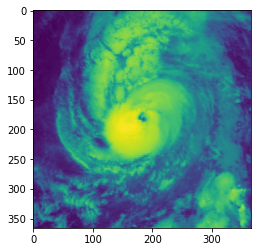

In [8]:
# The peak speed is at image 5. We can show the image to understand what the storm looks like at its fastest
img_fastest_speed = data.get_image("sss_005") # get the image
plt.imshow(img_fastest_speed[0,:,:]) # plot the image
print("The image at fastest speed at Image ID=sss_005", " at time ")
plt.show()

## Plot the image at slowest speed
slowest_speed_index = data.df['Wind Speed'].idxmin() # Get the index of data entry at the minimum speed
slowest_img = data.df['Image ID'][slowest_speed_index] # Get the image ID for the slowest speed
img_slowest_speed = data.get_image(slowest_img) # Get the image
plt.imshow(img_slowest_speed[0,:,:])  # Plot the image
print("The image at slowest speed at Image ID=",slowest_img, " at time", data.df['Relative Time'][slowest_speed_index])
plt.show()

## Plot a random image for quality check
random_index = random.randint(0, len(data.df))# Get the index of data entry at the minimum speed
random_img = data.df['Image ID'][random_index] # Get the image ID for the slowest speed
img_random = data.get_image(random_img) # Get the image
plt.imshow(img_random[0,:,:])  # Plot the image
print("The random image at at time", data.df['Relative Time'][random_index])
plt.show()
# 662399

After checking a series of images, we noticed that some images contain an imperfection. In particular, in the image below we can see a line crossing through the image. Plotting the images before and  after to check the consistency of the line, shows that it is a one off. This imperfection should not impact the quality of the predictions because it is only showing in 1 image. Given we are training over a series of images with about 10 images in a sequence, this would not have a large impact. 

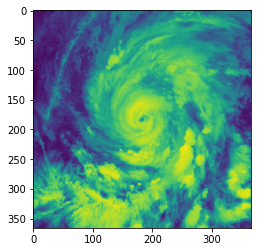

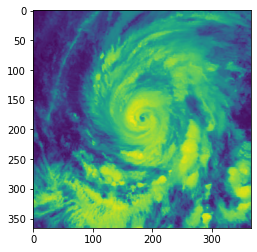

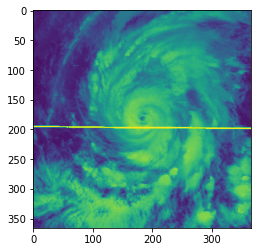

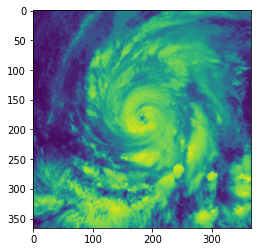

In [ ]:
imperfect_img_index = data.df.index[data.df['Relative Time']==662399][0]

for i in range(-2,2,1):
  img_imperfect_id = data.df['Image ID'][imperfect_img_index+i]
  img_imperfect = data.get_image(img_imperfect_id) # Get the image with line
  plt.imshow(img_imperfect[0,:,:])  # Plot the image
  plt.show()

## Machine Learning Model <a class="anchor" id="MLmodel"></a> 

### Data Preparation <a class="anchor" id="data_prep"></a>

The data exploration of the images has not highlighted any issues that might be cause for concern. Therefore we can proceed with preparing the data for model training. 

The data preparation requires the following steps:
* Combine images into a list and convert to tensor.


To train the model first the data should to be prepared. This requires tranforming it to required format and splitting the data into training, validation and test datasets.

In [7]:
# Create class for the training data to be parsed as tensor
data_for_model = HurricaneForecast.StormTensorDataset(data.df, "sss", num_sequence = 5, download_dir = download_directory, train_source=train_source)

# Calculate the mean and standard deviationi to be used in normalisation
mean, std = data_for_model.calculate_mean_std("sss")
print("The mean for the training dataset is", mean, " and the standard deviation is ", std)

All the data are in shape (366,366)
The mean for the training dataset is [0.45241618156433105]  and the standard deviation is  [0.21380861103534698]


In [8]:
from torch.utils.data.dataset import random_split
import torchvision.transforms as T
# dataloader = torch.utils.data.DataLoader(data_for_model, batch_size=4, shuffle = True)
train_size = int(len(data_for_model)* .8)
test_size = len(data_for_model) - train_size
realtrainset, validation_set = random_split(data_for_model, [train_size, test_size])
# b = dataset.get_tensor_combination("jvx_04, 6)
dataloader = torch.utils.data.DataLoader(realtrainset, batch_size=4, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle = True)
for i in dataloader:
  print(i[0].shape)
  print(i[1].shape)
  break

torch.Size([4, 5, 1, 366, 366])
torch.Size([4, 1, 1, 366, 366])


In [9]:
from HurricaneForecast import Train_Validate
from HurricaneForecast import pureLSTM
set_seed(5)
train_module = Train_Validate(device)
model = pureLSTM(366, device).to(device)

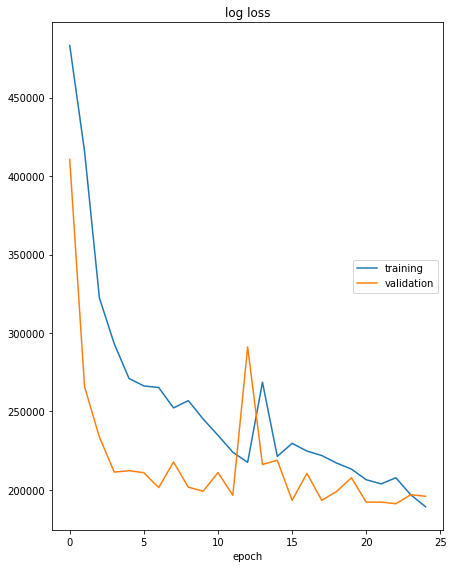

log loss
	training         	 (min: 189289.047, max: 483227.500, cur: 189289.047)
	validation       	 (min: 191199.250, max: 410613.469, cur: 195962.531)


In [10]:



lr = 3e-3
n_epochs = 25

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss = train_module.train(dataloader, optimizer, criterion, model)
    print(epoch, train_loss)
    logs['' + 'log loss'] = train_loss.item()
    logs['val_'+ 'log loss'] = train_module.validate(validation_loader, criterion, model).item()
    liveloss.update(logs)
    liveloss.draw()


0.45241618156433105
0.21380861103534698
single_img.shape tensor(0.8744, device='cuda:0', grad_fn=<MaxBackward1>)
single_img.shape tensor(0.0150, device='cuda:0', grad_fn=<MinBackward1>)
this is prediction


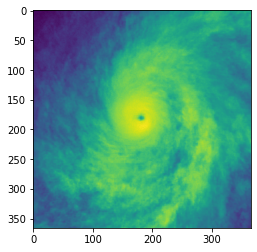

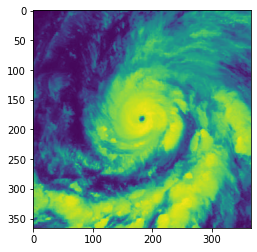

single_img.shape tensor(0.8696, device='cuda:0', grad_fn=<MaxBackward1>)
single_img.shape tensor(0.0621, device='cuda:0', grad_fn=<MinBackward1>)
this is prediction


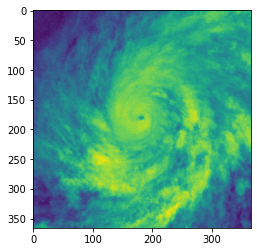

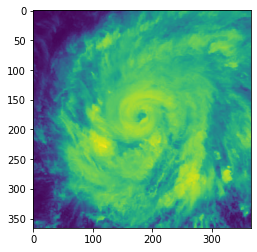

single_img.shape tensor(0.8744, device='cuda:0', grad_fn=<MaxBackward1>)
single_img.shape tensor(0.0150, device='cuda:0', grad_fn=<MinBackward1>)
this is prediction


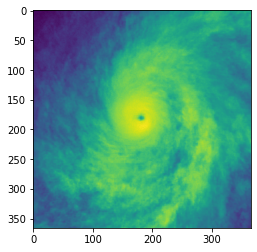

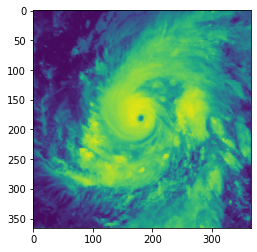

In [11]:
import PIL
model.eval()
testloader = torch.utils.data.DataLoader(validation_set, batch_size = 1)
transform = T.ToPILImage()
counter = 0
imgs = []
from PIL import Image
original_imgs = []
print(mean[0])
print(std[0])
for i, y in testloader:
  x = i.to(device)

  img = model(x)

  single_img = img.view(-1, 366, 366)[0, :]*std[0] +mean[0]
  print("single_img.shape",torch.max(single_img))
  print("single_img.shape",torch.min(single_img))

  imgs.append(single_img)
  plt.figure()
  print("this is prediction")
  plt.imshow(transform(single_img))  # Plot the image
  plt.show()
  plt.imshow(transform(y[0,0,0,:,:]*std[0]+mean[0]))  # Plot the image
  plt.show()
  counter += 1
  if counter>4:
    break


###To plot the last 5 imgs as predictions

prediction: 0  is shown


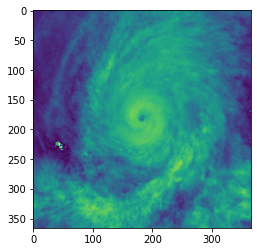

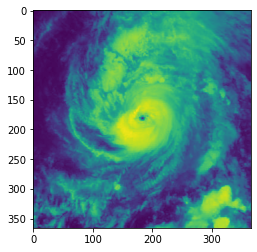

prediction: 1  is shown


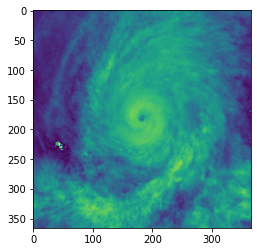

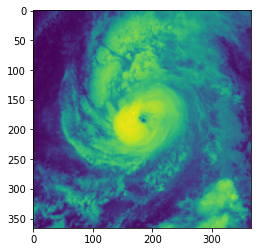

prediction: 2  is shown


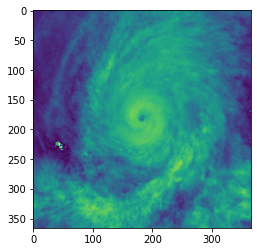

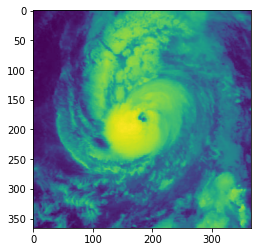

prediction: 3  is shown


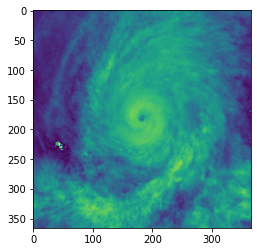

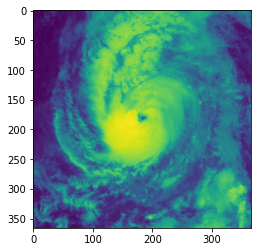

prediction: 4  is shown


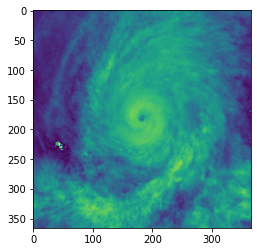

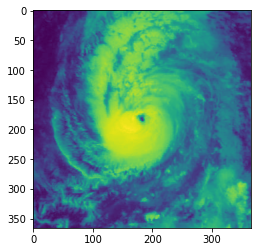

5
std: [0.26253448237867394, 0.26535141268826284, 0.26799164985989593, 0.27746716773481167, 0.2788586042624211]
ssim: [5472.590171399564, 5366.870823255397, 4797.886798650303, 4476.160828928902, 4295.69170473887]


In [10]:
x, y = data_for_model.get_last_10_img()
train_module.show_result_for_last_five(x, y, mean[0], std[0], model, device, seq_num = 5)


#For our second model

In [12]:
from HurricaneForecast import EncoderDecoderConvLSTM
set_seed(5)
model = EncoderDecoderConvLSTM(in_chan=1).to(device)

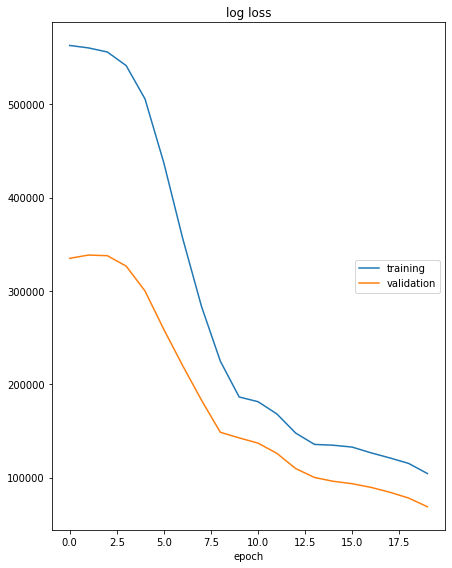

log loss
	training         	 (min: 104232.648, max: 562935.250, cur: 104232.648)
	validation       	 (min: 68680.156, max: 338358.938, cur: 68680.156)


In [13]:
lr = 3e-3
n_epochs = 20

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss = train_module.train(dataloader, optimizer, criterion, model)
    print(epoch, train_loss)
    logs['' + 'log loss'] = train_loss.item()
    logs['val_'+ 'log loss'] = train_module.validate(validation_loader, criterion, model).item()
    liveloss.update(logs)
    liveloss.draw()

prediction: 0  is shown


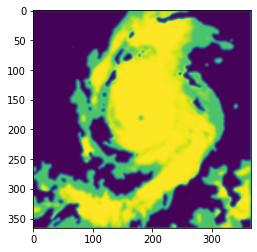

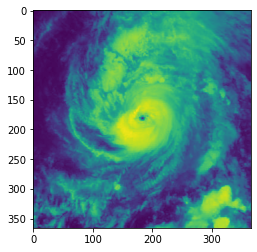

prediction: 1  is shown


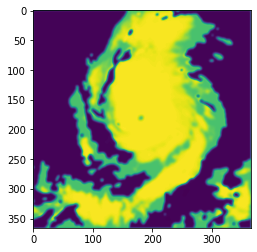

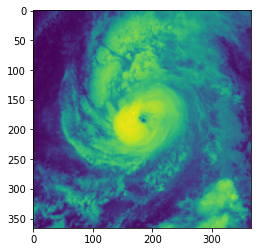

prediction: 2  is shown


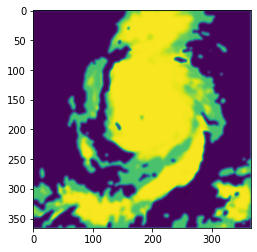

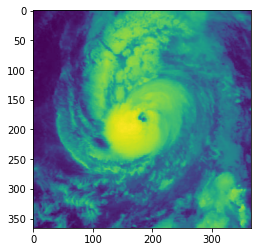

prediction: 3  is shown


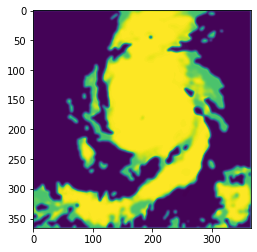

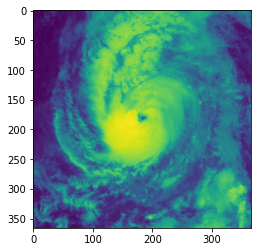

prediction: 4  is shown


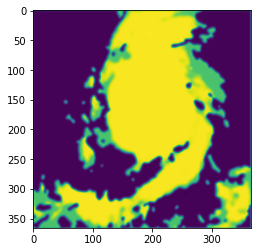

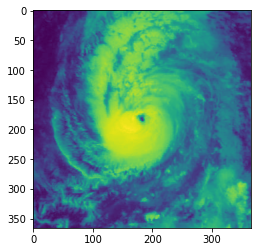

5
std: [0.5396504164812093, 0.5409697805795715, 0.5423278832531967, 0.5339792829536196, 0.5328867454110222]
ssim: [1837.4241019439219, 1797.3145958374391, 1829.9574113888143, 1985.3282794350384, 2099.7080907163545]


In [14]:
train_module.show_result_for_last_five(x, y, mean[0], std[0], model, device, seq_num = 5)